In [14]:
import numpy as np
import matplotlib.pyplot as plt
from modularities_notebooks.modularity import clustered_connections, print_weight_matrix, compute_density_matrix, plot_connection_matrices
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sys

if '/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages' not in sys.path:
    sys.path.append('/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages')
import torch
import snn_utils
from randman.randman import *
import matplotlib.pyplot as plt
import seaborn as sns
from randman_utils import *
from torch.utils.data import DataLoader, Dataset
from typing import Optional

from LIFlayer import NHiddenModel

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'device: {device}')
else:
    device = torch.device("cpu")
    print(f'device: {device}')

device: cuda


In [16]:
class RandmanDataset(Dataset):
    """Characterizes a PyTorch dataset for use with the PyTorch dataloader."""
    def __init__(self, data, labels):
        """Simple initialization of the given dataset."""
        self.data = data
        self.labels = labels

    def __len__(self):
        """Denotes the total number of samples"""
        return len(self.labels)

    def __getitem__(self, index):
        """Retrives a single sample from the given dataset."""
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]

        return X, y

def convert_spike_times_to_raster(spike_times: np.ndarray, timestep: float = 1.0, max_time: Optional[float] = None, num_neurons: Optional[int] = None, dtype=None):
    """
    Convert spike times array to spike raster array. 
    For now, all neurons need to have same number of spike times.
    
    Args:
        spike_times: MoreArrays, spiketimes as array of shape (batch_dim x spikes/neuron X 2)
            with final dim: (times, neuron_id)
    """

    if dtype is None:
        dtype = np.int16
    # spike_times = spike_times.astype(np.uint16)
    if num_neurons is None:
        num_neurons = int(np.nanmax(spike_times[:,:,1]))+1
    if max_time is None:
        max_time = np.nanmax(spike_times[:,:,0])
    num_bins = int(max_time / timestep + 1)

    spike_raster = np.zeros((spike_times.shape[0], num_bins, num_neurons), dtype=np.float32)
    batch_id = np.arange(spike_times.shape[0]).repeat(spike_times.shape[1])
    spike_times_flat = (spike_times[:, :, 0].flatten() / timestep).astype(dtype)
    neuron_ids = spike_times[:, :, 1].flatten().astype(dtype)
    np.add.at(spike_raster, (batch_id, spike_times_flat, neuron_ids), 1)
    return spike_raster


def make_spike_raster_dataset(nb_classes=10, nb_units=100, nb_steps=100, dim_manifold=2, nb_samples=1000, alpha=2.0, shuffle=True, seed=None):
# def make_spike_raster_dataset(nb_classes, nb_units, nb_steps, dim_manifold=2, nb_spikes=1, nb_samples=1000, alpha=2.0, shuffle=True):
# def make_spike_raster_dataset():
    spike_times,labels = make_spiking_dataset(nb_classes=nb_classes, nb_units=nb_units, nb_steps=nb_steps, dim_manifold=dim_manifold, seed=seed,nb_samples=nb_samples,shuffle=shuffle,alpha=alpha)
    spike_raster = convert_spike_times_to_raster(spike_times)
    return spike_raster, labels

def get_data_loaders(nb_classes, nb_units, nb_steps, nb_samples, batchsize):
    data, labels = make_spike_raster_dataset(nb_classes=nb_classes, nb_units=nb_units, nb_steps=nb_steps, nb_samples=nb_samples)

    NUM_SAMPLES_TOTAL = (nb_classes*nb_samples)
    NUM_SAMPLES_TRAIN = int(NUM_SAMPLES_TOTAL*0.8)

    data_train, labels_train = data[:NUM_SAMPLES_TRAIN], labels[:NUM_SAMPLES_TRAIN]
    data_test,  labels_test  = data[NUM_SAMPLES_TRAIN:], labels[NUM_SAMPLES_TRAIN:]

    dataset_train = RandmanDataset(data_train, labels_train)
    dataset_test = RandmanDataset(data_test, labels_test)

    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True, drop_last=True)
    dataloader_test = DataLoader(dataset_test, batch_size=batchsize, shuffle=True, drop_last=True)
    return dataloader_train, dataloader_test

In [ ]:
def get_Ws(N,nb_classes,epsilon=1, modularity =1,base_w = 1,w = 1,plot=True,device=device):
    n_assemblies = nb_classes
    ss = StandardScaler()
    mask, cluster_ids, _ = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=1./n_assemblies, modularity=modularity)
    mask = (mask* (base_w*w)) + base_w

    W, cluster_ids, t = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=epsilon, modularity=0.)
    if w > 0.:
        W *= base_w
        W *= mask

    if epsilon ==1:
        W = W-1
    W2 = (W != 0).astype(int)
    if plot:
        plt.title('W')
        plt.imshow(W)
        plt.colorbar()
        plt.show()
        plt.title('W2')
        plt.imshow(W2)
        plt.colorbar()
        plt.show()
    return torch.tensor(W,device=device,dtype=torch.float32), torch.tensor(W2,device=device,dtype=torch.float32)

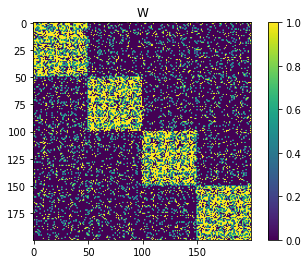

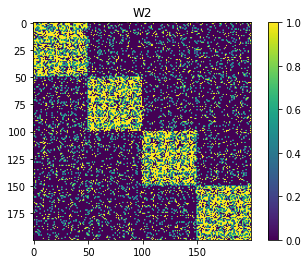

In [11]:
W,W2 = get_Ws(200,4,1,.8)

In [5]:
def acc_from_pred(prediction,y):

    return (y == prediction.argmax(axis=1)).sum()/len(prediction)

In [4]:
dataloader_train, dataloader_test = get_data_loaders(4,200,100,1000,50)

In [12]:
#def train(N,T,nb_classes,model,X_train,y_train,train_batch_ids,W,W2,lr,decay,epochs=100,use_W=False,use_W2=False,print_each=5,device='cpu'):
def train(T,dataloader_train,nb_classes,model,W,W2,lr,decay=.99,epochs=100,use_W=False,use_W2=False,print_each=5,device=device):
    #in_channels=N
    #hidden_channels = N
    #out_channels = nb_classes
    #model = FiveHiddenModel(in_channels,hidden_channels,out_channels,batch_size=batch_size,W=W)

    #mse_loss = torch.nn.MSELoss()
    ce_loss = torch.nn.CrossEntropyLoss()

    #apply W
    if use_W:
        model.init_mod_weights(W)

    #layer1.fc_layer.weight = torch.nn.Parameter(torch.Tensor(W))
    params = model.parameters()
    opt = torch.optim.Adam(params, lr=lr, betas=[0., .95]) #lr is the learning rate
    loss_hist = []
    acc_hist = []
    #epochs
    for e in range(epochs):
        batch_loss = 0
        batch_acc=0
        model.train()

        #batches

        #if e%10 == 0:
        #    y = model.layer1.fc_layer.weight.clone().detach()
        #    plt.imshow(y)
        #    plt.show()
        #plt.imshow(W)
        #plt.show()
        count = 0
        for x,label in dataloader_train:
            model.init_states()
            Sprobe = torch.zeros((dataloader_train.batch_size,model.out_channels),device=device)
            x = x.to(device)
            label=label.to(device)
            for n in range(T):
                out_state = model(x[:,n])

                Sprobe = decay * Sprobe + out_state.S

            
            prediction = Sprobe
            accuracy = acc_from_pred(prediction,label)
            loss = ce_loss(prediction,label)
            loss.backward()
            opt.step()
            opt.zero_grad()

#        for i in range(len(train_batch_ids)):
#        
#
#            model.init_states()
#            Sprobe = torch.zeros((batch_size,model.out_channels),device=device)
#            #out = torch.zeros((batch_size,model.out_channels),device=device)
#            #out_rec = [out]
#        #timesteps
#            for n in range(T):
#                out_state = model(X_train[train_batch_ids[i],n])
#
#            #add decay for leakiness
#            #collect spikes over time
#                Sprobe = decay * Sprobe + out_state.S
#                #out_rec.append(out_state.U)
#
#            #out_rec = torch.stack(out_rec,dim=1)
#            #prediction = torch.max(out_rec,1).values
#            prediction = Sprobe
#            accuracy = acc_from_pred(prediction,y_train[train_batch_ids[i]])
#            loss = ce_loss(prediction,y_train[train_batch_ids[i]])
#
#            loss.backward()
#            opt.step()
#            opt.zero_grad()
            if use_W2:
                model.init_mod_weights(W2)
            count+=1
            batch_acc = batch_acc + accuracy
            batch_loss = batch_loss + loss
        #epoch_acc = batch_acc/(len(train_batch_ids))
        epoch_acc = batch_acc/count
        epoch_loss = batch_loss/count
        #epoch_loss = batch_loss/(len(train_batch_ids))
        loss_hist = loss_hist + [float(epoch_loss)]
        acc_hist = acc_hist + [float(epoch_acc)]


        if e%print_each==0:
            print(f'epoch {e}: \n loss: {epoch_loss}')
            print(f'train_acc: {epoch_acc}')
    return loss_hist,acc_hist

In [8]:
model = NHiddenModel(num_hidden_layers=1,in_channels=200,hidden_channels=200,out_channels=4,with_recurrent=True).to(device)

In [13]:
loss, acc = train(T=100,dataloader_train=dataloader_train,nb_classes=4,epochs=30, model=model,use_W=False,use_W2=False,lr=1e-4,decay=.99,W=W,W2=W2,print_each=1,device=device)

epoch 0: 
 loss: 1.410290241241455
train_acc: 0.2490624636411667
epoch 1: 
 loss: 1.3909945487976074
train_acc: 0.265625
epoch 2: 
 loss: 1.3597846031188965
train_acc: 0.33249998092651367
epoch 3: 
 loss: 1.1998447179794312
train_acc: 0.5140625238418579
epoch 4: 
 loss: 0.7883641123771667
train_acc: 0.8118748664855957
epoch 5: 
 loss: 0.3400510549545288
train_acc: 0.9690622687339783
epoch 6: 
 loss: 0.19883263111114502
train_acc: 0.9621874690055847
epoch 7: 
 loss: 0.0524887815117836
train_acc: 0.9940624833106995
epoch 8: 
 loss: 0.061487726867198944
train_acc: 0.9831249713897705
epoch 9: 
 loss: 0.08436965942382812
train_acc: 0.9737499952316284
epoch 10: 
 loss: 0.0039001270197331905
train_acc: 1.0
epoch 11: 
 loss: 0.05024445056915283
train_acc: 0.9874999523162842
epoch 12: 
 loss: 0.010088247247040272
train_acc: 0.9965624809265137
epoch 13: 
 loss: 0.17258226871490479
train_acc: 0.9609375
epoch 14: 
 loss: 0.0015184353105723858
train_acc: 1.0
epoch 15: 
 loss: 0.125166654586792
trai

In [ ]:
#do something with forward hooks